In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
from tqdm import tqdm

%matplotlib inline

In [2]:
ref = pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\ngdbrock-fUS56\tblRockGeoData.csv', index_col = [0])

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (12,14,26,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})

In [4]:

from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(ref.longitude, ref.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(ref, crs={'init': 'epsg:4326'}, geometry=geometry)
#geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)
val_huc = gpd.sjoin(huc12, projGeoDF)

In [5]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [6]:
val_huc = val_huc.merge(data, on='lab_id') #this is the chemical data joined with the HUC dataset

NameError: name 'data' is not defined

In [ ]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)
frame['HUC_12']=frame.HUC_12.astype(str)
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [78]:
true_vals = []
for samples in tqdm(range(len(val_huc))):
    true_vals.append(val_huc.loc[samples].HUC_12)

bflat = []  
for samples in tqdm(range(4)):#len(val_huc))):
    formation = val_huc.loc[samples].stratgrphy[0:10]
    b = []
    for element in range(58,113):
        ppm = val_huc.columns[element] #select each element in the list
        valued = val_huc.loc[samples][element] #select each elements values 
        #from the big list, select element, formation, and concentration greater than the sample has, and create a list of the
        #basins that we should explore
        b0 = CaptainHucstable[(CaptainHucstable['element']== ppm) & (CaptainHucstable['formation'].str.contains(formation)) &(
            CaptainHucstable['bins_ppm']>= valued) & (CaptainHucstable['prob']>0.1)].HUC_12.values
        b.append(b0)
    bflat.append(np.unique(np.asarray([item for sublist in b for item in sublist])))
preds = np.unique(np.asarray([item for sublist in bflat for item in sublist]))
TP = len(set(true_vals).intersection(preds))
FP = len(preds)-len(set(true_vals).intersection(preds))
TN = len(huc12.HUC_12.unique())-len(preds)
FN = len(set(true_vals).intersection(set(huc12.HUC_12.unique()) ^ set(preds)))

#precision = TP/(TP+FP)
#recall = TP/(TP+FN)
#acc = (TP+TN)/(TP+TN+FP+FN)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:25<00:00, 96.37s/it]


In [79]:
print([TP, FP, TN, FN])

[0, 0, 2382, 106]


Let's try something other than predicting locations

In [79]:
path = r'J:\\Geology\\WSGS\\GIS\\Predicted locations\\'
allFiles=glob.glob(path+"*.shp")
points = gpd.read_file(r'J:\Geology\WSGS\GIS\usgs_locations.shp')
points= points.to_crs({'init': 'epsg:3732'})

validations = []
for shapefile in allFiles:
    shape = gpd.read_file(shapefile)
    shape = shape.to_crs({'init': 'epsg:3732'})
    chosen = gpd.sjoin(points, shape)
    chosen['element'] = shapefile[-10:-4]
    validations.append(chosen)

In [95]:
selectedSamples = pd.concat(validations)

In [85]:
selectedSamples.to_file(driver='ESRI Shapefile', filename='usgs_samples_clipped.shp')

AttributeError: 'DataFrame' object has no attribute 'to_file'

# starting validation of predicted values

In [3]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\ngdbrock-fUS56\\ngdbrock-fUS56\\'
allFiles=glob.glob(path+"*.csv")

es = pd.read_csv(allFiles[0], index_col = [0])
paes = pd.read_csv(allFiles[1], index_col = [0])
pms = pd.read_csv(allFiles[2], index_col = [0])
naa = pd.read_csv(allFiles[3], index_col = [0])
other = pd.read_csv(allFiles[4], index_col = [0])
unk = pd.read_csv(allFiles[5], index_col = [0])
xrf = pd.read_csv(allFiles[6], index_col = [0])

In [22]:
bl =  pd.read_csv(r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\ngdbrock-fUS56\\ngdbrock-fUS56\\bearlodge.csv', 
                  index_col = 'lab_id')

In [32]:
crustal_abundance=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\crustal_abundance1.csv',encoding = "ISO-8859-1")
ca = crustal_abundance.set_index('source').T

In [69]:
crustal_abundance.cr_ppm[5]

158.4

In [112]:
#es[es.index.isin(bl.index)].mn_ppm
#paes[paes.index.isin(bl.index)].cr_ppm
#pms[pms.index.isin(bl.index)].mnppm_ms
#naa[naa.index.isin(bl.index)].cr_ppm
#other[other.index.isin(bl.index)].cr_ppm
unk[unk.index.isin(bl.index)].mn_ppm[120:170]
#xrf[xrf.index.isin(bl.index)].mn_ppm


lab_id
D215829      1500.0
D215830      3000.0
D215831        70.0
D215832      7000.0
D215833      3000.0
D215834      3000.0
D215835      3000.0
D215836      2000.0
D215837     15000.0
D215838     15000.0
D215839      1500.0
D215840      3000.0
D215841      1500.0
D215842      1500.0
D215843      1500.0
D215844       700.0
D215845       300.0
D215846       300.0
D215847      7000.0
D215848      3000.0
D215849      3000.0
D215850     15000.0
D215851      3000.0
D215852      7000.0
D215853      5000.0
D215854      3000.0
D215855      3000.0
D215856       150.0
D215857        70.0
D215858        70.0
D215859      7000.0
D215860       700.0
D215861       150.0
D215862       150.0
D215863       150.0
D215864       150.0
D215865       150.0
D215866       200.0
D215867      1500.0
D215868       700.0
D216734       500.0
D216735      7000.0
D216736      7000.0
D216737       700.0
D216738     70000.0
D216739    100000.0
D216740    100000.0
D216741     10000.0
D216742      7000.0
D216743     1

In [224]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(es2.longitude, es2.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = gpd.GeoDataFrame(es2, crs={'init': 'epsg:4326'}, geometry=geometry)
points=geo_df.to_crs(crs)

In [136]:
path = r'J:\\Geology\\WSGS\\GIS\\Predicted locations\\'
allFiles=glob.glob(path+"*.shp")

validations = []
for shapefile in allFiles:
    shape = gpd.read_file(shapefile)
    shape = shape.to_crs({'init': 'epsg:3732'})
    chosen = gpd.sjoin(points, shape)
    chosen['element'] = shapefile[-10:-4]
    validations.append(chosen)

In [137]:
#selectedSamples = pd.concat(validations)
#selectedSamples.to_file(driver='ESRI Shapefile', filename='naa_samples_clipped.shp')

bring in the clipped sample points

In [225]:
t = gpd.read_file(r'D:\jupyter\es_samples_clipped.shp')
t.columns

Index(['ACRES', 'AREA', 'FID_BLM__S', 'FID_lessth', 'HOLDAGENCY', 'Id',
       'NCONTRB_A', 'Name', 'OBJECTID', 'PERIMETER', 'SMA_ID', 'SURFACE',
       'Shape_Ar_1', 'Shape_Area', 'Shape_Le_1', 'Shape_Leng', 'WY_HU12_',
       'addl_attr', 'alteration', 'bins_ppm', 'country', 'date_sub',
       'date_sub2', 'datecollct', 'datum', 'dep_envirn', 'depth', 'element',
       'facies_grd', 'field_id', 'geol_age', 'gridcode', 'idx1', 'idx2',
       'index_righ', 'job_id', 'lab_id', 'latitude', 'locat_desc', 'longitude',
       'mesh_size', 'metamrphsm', 'methcollct', 'mineralztn', 'prep',
       'primeclass', 'prob', 'sample_src', 'source_rk', 'spec_name',
       'spheroid', 'state', 'stratgrphy', 'struct_src', 'submitter',
       'xndryclass', 'geometry'],
      dtype='object')

In [227]:
predicted = []
actuals = []
for i in range(len(t)):
    try:
        actuals.append(t.iloc[i][t.iloc[i].element])
        predicted.append(5*ca[ca.index== t.iloc[i].element].mean_ppm.values[0])
    except:
        actuals.append(0)
        predicted.append(0)

        

In [228]:
flat_preds = np.asarray(predicted)

In [229]:
flat_actual = np.asarray(actuals)

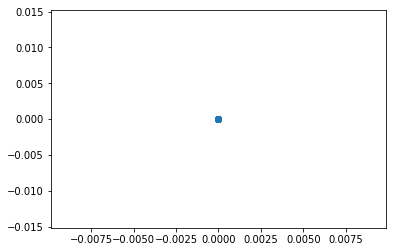

In [230]:
plt.scatter(flat_preds, flat_actual)

In [231]:
t['predicted'] = flat_preds
t['actual'] = flat_actual

In [232]:
t.fillna(0, inplace=True)
t['actual'].replace('None', 0, inplace=True)

In [233]:
from sklearn.metrics import mean_squared_error

rmse = []
for i in range(len(t.element.unique())):
    try:
        rmse.append(np.sqrt(mean_squared_error(t[t['element'] == t.element.unique()[i]].actual, t[t['element'] == 
                                                                                  t.element.unique()[i]].predicted)))
    except:
        rmse.append(np.nan)

In [234]:
rmse

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [235]:
t.element.unique()

array(['ag_ppm', 'al_pct', 'as_ppm', 'ba_ppm', 'be_ppm', 'bi_ppm',
       '\\b_ppm', 'ca_pct', 'cd_ppm', 'ce_ppm', 'cl_ppm', 'co_ppm',
       'cr_ppm', 'cs_ppm', 'cu_ppm', 'dy_ppm', 'eu_ppm', 'fe_pct',
       'hf_ppm', '\\k_pct', 'la_ppm', 'li_ppm', 'mg_pct', 'mn_ppm',
       'mo_ppm', 'na_pct', 'nb_ppm', 'ni_ppm', 'pb_ppm', '\\p_ppm',
       'rb_ppm', 'sb_ppm', 'sc_ppm', 'se_ppm', 'sm_ppm', 'sn_ppm',
       'sr_ppm', 'th_ppm', 'ti_ppm', 'dn_ppm', 'fl_ppm', '\\v_ppm',
       '\\w_ppm', 'yb_ppm', '\\y_ppm', 'zn_ppm'], dtype=object)

In [236]:
deets = pd.DataFrame([rmse], columns =t.element.unique() )


In [237]:
deets.to_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\ngdbrock-fUS56\accuracy\es.csv')

In [127]:
path = r'J:\\Geology\\WSGS\\GIS\\Predicted locations\\critical only\\'
allFiles=glob.glob(path+"*.shp")
geo_frame=pd.DataFrame
listed=[]
for file in allFiles:
    gdf = gpd.read_file(file)
    listed.append(gdf)
geo_frame = pd.concat(listed)


In [148]:
geo_frame.groupby('WY_HU12_').count()

,ACRES,AREA,FID_BLM__S,FID_lessth,HOLDAGENCY,Id,NCONTRB_A,Name,OBJECTID,PERIMETER,...,Shape_Area,Shape_Le_1,Shape_Leng,bins_ppm,element,geometry,gridcode,idx1,idx2,prob
WY_HU12_,,,,,,,,,,,,,,,,,,,,,
2133,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4376,1,1,0,0,0,0,1,0,0,1,...,1,0,1,1,0,1,0,0,0,1
4658,1,1,0,0,0,0,1,0,0,1,...,1,0,1,1,0,1,0,0,0,1
5890,3,3,0,0,0,0,3,0,0,3,...,3,0,3,3,0,3,0,0,0,3
6264,15,15,15,15,0,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
6693,1,1,0,0,0,0,1,0,0,1,...,1,0,1,1,0,1,0,0,0,1
6972,4,4,0,0,0,0,4,0,0,4,...,4,0,4,4,0,4,0,0,0,4
7208,1,1,0,0,0,0,1,0,0,1,...,1,0,1,1,0,1,0,0,0,1
7989,2,2,0,0,0,0,2,0,0,2,...,2,0,2,2,0,2,0,0,0,2


In [149]:
geo_frame[geo_frame['WY_HU12_'] == 14774] #somewhere I crushed the HUC name along the line. need to do a spatial join with these and the HUC original shapefile

,ACRES,AREA,FID_BLM__S,FID_lessth,HOLDAGENCY,Id,NCONTRB_A,Name,OBJECTID,PERIMETER,...,Shape_Le_1,Shape_Leng,WY_HU12_,bins_ppm,element,geometry,gridcode,idx1,idx2,prob
0,698517.861461,0.313593,5027.0,469.0,None,470.0,539354.891408,State,5028.0,10.388769,...,10.388769,8814.675338,14774,66.0,w_ppm,"POLYGON ((2598549.063915645 904087.6454739592,...",1.0,6190.0,48.0,7.923077
1,698517.861461,0.313593,5170.0,469.0,None,470.0,539354.891408,State,5171.0,10.388769,...,10.388769,5493.943235,14774,66.0,w_ppm,"POLYGON ((2618903.673079832 960709.0580483323,...",1.0,6333.0,48.0,7.923077
2,698517.861461,0.313593,5368.0,469.0,None,470.0,539354.891408,State,5369.0,10.388769,...,10.388769,8835.766300,14774,66.0,w_ppm,"POLYGON ((2619010.529485315 918357.3446673808,...",1.0,6531.0,48.0,7.923077
3,698517.861461,0.313593,5384.0,469.0,None,470.0,539354.891408,State,5385.0,10.388769,...,10.388769,8797.590218,14774,66.0,w_ppm,"POLYGON ((2587345.113011874 922499.3660643137,...",1.0,6547.0,48.0,7.923077
4,698517.861461,0.313593,5400.0,469.0,None,470.0,539354.891408,State,5401.0,10.388769,...,10.388769,8779.976678,14774,66.0,w_ppm,"POLYGON ((2634252.548585362 934832.7413321731,...",1.0,6563.0,48.0,7.923077
5,698517.861461,0.313593,5448.0,469.0,None,470.0,539354.891408,State,5449.0,10.388769,...,10.388769,8826.242752,14774,66.0,w_ppm,"POLYGON ((2631151.240013219 902916.0408355888,...",1.0,6611.0,48.0,7.923077
6,698517.861461,0.313593,5459.0,469.0,None,470.0,539354.891408,State,5460.0,10.388769,...,10.388769,8786.687220,14774,66.0,w_ppm,"POLYGON ((2614021.925065104 950035.2937411017,...",1.0,6622.0,48.0,7.923077
7,698517.861461,0.313593,5901.0,469.0,None,470.0,539354.891408,State,5902.0,10.388769,...,10.388769,5528.539525,14774,66.0,w_ppm,"POLYGON ((2638992.484842058 945446.5254852483,...",1.0,7064.0,48.0,7.923077
8,698517.861461,0.313593,5902.0,469.0,None,470.0,539354.891408,State,5903.0,10.388769,...,10.388769,8712.063183,14774,66.0,w_ppm,"POLYGON ((2597357.476230347 938867.5576329664,...",1.0,7065.0,48.0,7.923077
9,698517.861461,0.313593,15937.0,469.0,None,470.0,539354.891408,Bureau of Land Management,15938.0,10.388769,...,10.388769,4396.275982,14774,66.0,w_ppm,"POLYGON ((2613526.481937299 961864.861624116, ...",1.0,16888.0,48.0,7.923077


In [144]:
gdf

,idx1,idx2,FID_lessth,Id,gridcode,FID_BLM__S,OBJECTID,SURFACE,HOLDAGENCY,SMA_ID,...,PERIMETER,WY_HU12_,ACRES,NCONTRB_A,Shape_Le_1,Shape_Ar_1,bins_ppm,prob,element,geometry
0,6190,48,469,470,1,5027,5028,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2598549.063915645 904087.6454739592,..."
1,6333,48,469,470,1,5170,5171,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2618903.673079832 960709.0580483323,..."
2,6531,48,469,470,1,5368,5369,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2619010.529485315 918357.3446673808,..."
3,6547,48,469,470,1,5384,5385,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2587345.113011874 922499.3660643137,..."
4,6563,48,469,470,1,5400,5401,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2634252.548585362 934832.7413321731,..."
5,6611,48,469,470,1,5448,5449,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2631151.240013219 902916.0408355888,..."
6,6622,48,469,470,1,5459,5460,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2614021.925065104 950035.2937411017,..."
7,7064,48,469,470,1,5901,5902,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2638992.484842058 945446.5254852483,..."
8,7065,48,469,470,1,5902,5903,State,None,2386,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2597357.476230347 938867.5576329664,..."
9,16888,48,469,470,1,15937,15938,Bureau of Land Management,None,2,...,10.388769,14774,698517.861461,539354.891408,10.388769,0.313593,66.0,7.923077,w_ppm,"POLYGON ((2613526.481937299 961864.861624116, ..."
